In [1]:
from transformers import BertTokenizer
import pandas as pd
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch
from transformers import AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
source_folder = 'source_folder'
saved_folder = 'saved_folder'

In [3]:
device = torch.device('cuda:0')

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
max_len = 35
BATCH_SIZE = 8
pad_index = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
unk_index = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

label_field = Field(sequential = False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, tokenize = tokenizer.encode, include_lengths=False, 
                   batch_first=True, fix_length=max_len,pad_token = pad_index,unk_token=unk_index)
fields = [('sentences', text_field), ('label', label_field)]



train, dev, test = TabularDataset.splits(path=source_folder, train='train_df.csv',
                                           validation='dev_df.csv',
                                           test='test_df.csv', format='CSV', 
                                           fields=fields, skip_header=True)


train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.sentences),
                            device=device, train=True, sort=True, sort_within_batch=True)
dev_iter = BucketIterator(dev, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.sentences),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [6]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [7]:
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification

In [8]:
# Model with extra layers on top of RoBERTa
class BertClassifier(torch.nn.Module):
    def __init__(self):
        super(BertClassifier,self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    
    def forward(self,input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask = attention_mask)
        return x

In [9]:
def train(model, optimizer, train_iter, dev_iter, epochs, scheduler):
    model.train()
    train_loss = 0.0
    dev_loss = 0.0
    global_step = 0
    
    for epoch in range(epochs):
        count = 0
        for (source, target), _ in train_iter:
            mask = (source!=pad_index).type(torch.uint8)
            y_pred = model(input_ids = source, attention_mask=mask)[0]
            loss = torch.nn.CrossEntropyLoss()(y_pred,target)
            print('batch_no[{}/{}]:'.format(count, int(len(train_iter))),'training_loss:', loss)
            count+=1
            loss.backward()
            
            scheduler.step()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss == loss.item()
            global_step += 1
            
            if global_step% len(train_iter)==0:
                model.eval()
                
                with torch.no_grad():
                    for (source,target), _ in dev_iter:
                        mask = (source != pad_index).type(torch.uint8)
                        
                        y_pred = model(input_ids = source, attention_mask = mask)[0]
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        dev_loss += loss.item()
                        
                train_loss = train_loss/ len(train_iter)
                dev_loss = dev_loss/len(dev_iter)
                
                model.train()
                print('Epoch [{}/{}],global step [{}/{}], pt loss:{:.4f}, dev loss:{:.4f}'.format(epoch+1, epochs, 
                                                                                                  global_step, 
                                                                                                  epochs*len(train_iter),
                                                                                                 train_loss,
                                                                                          dev_loss))
                train_loss = 0.0
                dev_loss = 0.0

In [10]:
model = BertClassifier().to(device)  
NUM_EPOCHS = 5
steps_per_epoch = len(train_iter)
optimizer = AdamW(model.parameters(),lr=2e-6,weight_decay=0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*4, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model = model, train_iter=train_iter, dev_iter=dev_iter,optimizer=optimizer,
      epochs = NUM_EPOCHS,scheduler=scheduler)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

batch_no[0/1442]: training_loss: tensor(0.5488, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1/1442]: training_loss: tensor(0.5933, device='cuda:0', grad_fn=<NllLossBackward>)


F:\conda\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


batch_no[2/1442]: training_loss: tensor(0.4623, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[3/1442]: training_loss: tensor(0.6321, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[4/1442]: training_loss: tensor(0.6293, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[5/1442]: training_loss: tensor(0.4720, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[6/1442]: training_loss: tensor(0.7055, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[7/1442]: training_loss: tensor(0.4579, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[8/1442]: training_loss: tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[9/1442]: training_loss: tensor(0.5607, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[10/1442]: training_loss: tensor(0.6053, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[11/1442]: training_loss: tensor(0.4606, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[12/1442]: training_loss: tensor(0.4638, device='cuda:0', grad_fn=<Nll

batch_no[92/1442]: training_loss: tensor(0.5608, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[93/1442]: training_loss: tensor(0.5108, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[94/1442]: training_loss: tensor(0.5809, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[95/1442]: training_loss: tensor(0.7260, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[96/1442]: training_loss: tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[97/1442]: training_loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[98/1442]: training_loss: tensor(0.6150, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[99/1442]: training_loss: tensor(0.7573, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[100/1442]: training_loss: tensor(0.7171, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[101/1442]: training_loss: tensor(0.7670, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[102/1442]: training_loss: tensor(0.6186, device='cuda:0', g

batch_no[182/1442]: training_loss: tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[183/1442]: training_loss: tensor(0.4434, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[184/1442]: training_loss: tensor(0.4753, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[185/1442]: training_loss: tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[186/1442]: training_loss: tensor(0.5133, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[187/1442]: training_loss: tensor(0.7732, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[188/1442]: training_loss: tensor(0.9007, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[189/1442]: training_loss: tensor(0.9159, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[190/1442]: training_loss: tensor(0.4770, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[191/1442]: training_loss: tensor(0.6252, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[192/1442]: training_loss: tensor(0.7456, device='cu

batch_no[272/1442]: training_loss: tensor(0.5047, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[273/1442]: training_loss: tensor(0.5559, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[274/1442]: training_loss: tensor(0.6808, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[275/1442]: training_loss: tensor(0.5208, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[276/1442]: training_loss: tensor(0.5990, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[277/1442]: training_loss: tensor(0.5764, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[278/1442]: training_loss: tensor(0.5185, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[279/1442]: training_loss: tensor(0.5470, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[280/1442]: training_loss: tensor(0.5455, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[281/1442]: training_loss: tensor(0.4832, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[282/1442]: training_loss: tensor(0.5201, device='cu

batch_no[362/1442]: training_loss: tensor(0.5820, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[363/1442]: training_loss: tensor(0.6100, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[364/1442]: training_loss: tensor(0.6880, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[365/1442]: training_loss: tensor(0.6492, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[366/1442]: training_loss: tensor(0.7304, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[367/1442]: training_loss: tensor(0.5713, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[368/1442]: training_loss: tensor(0.5460, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[369/1442]: training_loss: tensor(0.4306, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[370/1442]: training_loss: tensor(0.4305, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[371/1442]: training_loss: tensor(0.6614, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[372/1442]: training_loss: tensor(0.5569, device='cu

batch_no[452/1442]: training_loss: tensor(0.5543, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[453/1442]: training_loss: tensor(0.4313, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[454/1442]: training_loss: tensor(0.6286, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[455/1442]: training_loss: tensor(0.8838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[456/1442]: training_loss: tensor(0.6995, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[457/1442]: training_loss: tensor(0.5251, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[458/1442]: training_loss: tensor(0.8375, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[459/1442]: training_loss: tensor(0.5687, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[460/1442]: training_loss: tensor(0.6582, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[461/1442]: training_loss: tensor(0.5940, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[462/1442]: training_loss: tensor(0.6447, device='cu

batch_no[542/1442]: training_loss: tensor(0.5194, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[543/1442]: training_loss: tensor(0.8742, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[544/1442]: training_loss: tensor(0.5236, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[545/1442]: training_loss: tensor(0.5141, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[546/1442]: training_loss: tensor(0.6921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[547/1442]: training_loss: tensor(0.5594, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[548/1442]: training_loss: tensor(0.5302, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[549/1442]: training_loss: tensor(0.5840, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[550/1442]: training_loss: tensor(0.4212, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[551/1442]: training_loss: tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[552/1442]: training_loss: tensor(0.8529, device='cu

batch_no[632/1442]: training_loss: tensor(0.6292, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[633/1442]: training_loss: tensor(0.6063, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[634/1442]: training_loss: tensor(0.5510, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[635/1442]: training_loss: tensor(0.7837, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[636/1442]: training_loss: tensor(0.8574, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[637/1442]: training_loss: tensor(0.7468, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[638/1442]: training_loss: tensor(0.8889, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[639/1442]: training_loss: tensor(0.5772, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[640/1442]: training_loss: tensor(0.5010, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[641/1442]: training_loss: tensor(0.5625, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[642/1442]: training_loss: tensor(0.5247, device='cu

batch_no[722/1442]: training_loss: tensor(0.7244, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[723/1442]: training_loss: tensor(0.5198, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[724/1442]: training_loss: tensor(0.6437, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[725/1442]: training_loss: tensor(0.5095, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[726/1442]: training_loss: tensor(0.6491, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[727/1442]: training_loss: tensor(0.5225, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[728/1442]: training_loss: tensor(0.5504, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[729/1442]: training_loss: tensor(0.6079, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[730/1442]: training_loss: tensor(0.4697, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[731/1442]: training_loss: tensor(0.4977, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[732/1442]: training_loss: tensor(0.6074, device='cu

batch_no[812/1442]: training_loss: tensor(0.8996, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[813/1442]: training_loss: tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[814/1442]: training_loss: tensor(0.8394, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[815/1442]: training_loss: tensor(0.5419, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[816/1442]: training_loss: tensor(0.4059, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[817/1442]: training_loss: tensor(0.4622, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[818/1442]: training_loss: tensor(0.5344, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[819/1442]: training_loss: tensor(0.9806, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[820/1442]: training_loss: tensor(0.8361, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[821/1442]: training_loss: tensor(0.9440, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[822/1442]: training_loss: tensor(0.4817, device='cu

batch_no[902/1442]: training_loss: tensor(0.6122, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[903/1442]: training_loss: tensor(0.4348, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[904/1442]: training_loss: tensor(0.7898, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[905/1442]: training_loss: tensor(0.7519, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[906/1442]: training_loss: tensor(0.4739, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[907/1442]: training_loss: tensor(0.7583, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[908/1442]: training_loss: tensor(0.5342, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[909/1442]: training_loss: tensor(0.5558, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[910/1442]: training_loss: tensor(0.5818, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[911/1442]: training_loss: tensor(0.8902, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[912/1442]: training_loss: tensor(0.6028, device='cu

batch_no[992/1442]: training_loss: tensor(0.7710, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[993/1442]: training_loss: tensor(0.5644, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[994/1442]: training_loss: tensor(0.8096, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[995/1442]: training_loss: tensor(0.5558, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[996/1442]: training_loss: tensor(0.5648, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[997/1442]: training_loss: tensor(0.5039, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[998/1442]: training_loss: tensor(0.6188, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[999/1442]: training_loss: tensor(0.7474, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1000/1442]: training_loss: tensor(0.6342, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1001/1442]: training_loss: tensor(0.7753, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1002/1442]: training_loss: tensor(0.4983, device=

batch_no[1079/1442]: training_loss: tensor(0.5557, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1080/1442]: training_loss: tensor(0.5190, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1081/1442]: training_loss: tensor(0.9261, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1082/1442]: training_loss: tensor(0.8247, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1083/1442]: training_loss: tensor(0.8087, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1084/1442]: training_loss: tensor(0.5196, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1085/1442]: training_loss: tensor(0.8642, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1086/1442]: training_loss: tensor(0.6739, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1087/1442]: training_loss: tensor(0.5580, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1088/1442]: training_loss: tensor(0.7166, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1089/1442]: training_loss: tensor(0.6341,

batch_no[1166/1442]: training_loss: tensor(0.4795, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1167/1442]: training_loss: tensor(0.6122, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1168/1442]: training_loss: tensor(0.6809, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1169/1442]: training_loss: tensor(1.0829, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1170/1442]: training_loss: tensor(0.5870, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1171/1442]: training_loss: tensor(0.5508, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1172/1442]: training_loss: tensor(0.7028, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1173/1442]: training_loss: tensor(0.6678, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1174/1442]: training_loss: tensor(0.5596, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1175/1442]: training_loss: tensor(0.7444, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1176/1442]: training_loss: tensor(0.5875,

batch_no[1253/1442]: training_loss: tensor(0.5429, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1254/1442]: training_loss: tensor(0.6737, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1255/1442]: training_loss: tensor(0.7642, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1256/1442]: training_loss: tensor(0.4208, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1257/1442]: training_loss: tensor(0.5857, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1258/1442]: training_loss: tensor(0.6812, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1259/1442]: training_loss: tensor(0.5595, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1260/1442]: training_loss: tensor(0.6629, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1261/1442]: training_loss: tensor(0.6202, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1262/1442]: training_loss: tensor(0.6395, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1263/1442]: training_loss: tensor(0.8174,

batch_no[1340/1442]: training_loss: tensor(0.5948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1341/1442]: training_loss: tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1342/1442]: training_loss: tensor(0.6160, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1343/1442]: training_loss: tensor(0.7904, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1344/1442]: training_loss: tensor(0.6468, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1345/1442]: training_loss: tensor(0.6577, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1346/1442]: training_loss: tensor(0.7616, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1347/1442]: training_loss: tensor(0.6470, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1348/1442]: training_loss: tensor(0.8067, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1349/1442]: training_loss: tensor(0.4888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1350/1442]: training_loss: tensor(0.5938,

batch_no[1427/1442]: training_loss: tensor(0.7267, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1428/1442]: training_loss: tensor(0.5806, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1429/1442]: training_loss: tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1430/1442]: training_loss: tensor(0.5709, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1431/1442]: training_loss: tensor(0.5680, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1432/1442]: training_loss: tensor(0.6864, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1433/1442]: training_loss: tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1434/1442]: training_loss: tensor(0.6860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1435/1442]: training_loss: tensor(0.6412, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1436/1442]: training_loss: tensor(0.6640, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1437/1442]: training_loss: tensor(0.6449,

batch_no[75/1442]: training_loss: tensor(0.3671, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[76/1442]: training_loss: tensor(0.7178, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[77/1442]: training_loss: tensor(0.6239, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[78/1442]: training_loss: tensor(0.4093, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[79/1442]: training_loss: tensor(0.5395, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[80/1442]: training_loss: tensor(0.5062, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[81/1442]: training_loss: tensor(0.6418, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[82/1442]: training_loss: tensor(0.3626, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[83/1442]: training_loss: tensor(0.4548, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[84/1442]: training_loss: tensor(0.4596, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[85/1442]: training_loss: tensor(0.3608, device='cuda:0', grad

batch_no[165/1442]: training_loss: tensor(0.6127, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[166/1442]: training_loss: tensor(0.5577, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[167/1442]: training_loss: tensor(0.7580, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[168/1442]: training_loss: tensor(0.5363, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[169/1442]: training_loss: tensor(0.3370, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[170/1442]: training_loss: tensor(0.4480, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[171/1442]: training_loss: tensor(0.6362, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[172/1442]: training_loss: tensor(0.5632, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[173/1442]: training_loss: tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[174/1442]: training_loss: tensor(0.5392, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[175/1442]: training_loss: tensor(0.4418, device='cu

batch_no[254/1442]: training_loss: tensor(0.4056, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[255/1442]: training_loss: tensor(0.5661, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[256/1442]: training_loss: tensor(0.4793, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[257/1442]: training_loss: tensor(0.5832, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[258/1442]: training_loss: tensor(0.4664, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[259/1442]: training_loss: tensor(0.5479, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[260/1442]: training_loss: tensor(0.4421, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[261/1442]: training_loss: tensor(0.4394, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[262/1442]: training_loss: tensor(0.5370, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[263/1442]: training_loss: tensor(0.2951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[264/1442]: training_loss: tensor(0.3200, device='cu

batch_no[344/1442]: training_loss: tensor(0.5070, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[345/1442]: training_loss: tensor(0.6402, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[346/1442]: training_loss: tensor(0.9346, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[347/1442]: training_loss: tensor(0.5402, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[348/1442]: training_loss: tensor(0.5533, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[349/1442]: training_loss: tensor(0.4463, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[350/1442]: training_loss: tensor(0.4541, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[351/1442]: training_loss: tensor(0.4500, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[352/1442]: training_loss: tensor(0.5582, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[353/1442]: training_loss: tensor(0.3370, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[354/1442]: training_loss: tensor(0.6784, device='cu

batch_no[434/1442]: training_loss: tensor(0.5380, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[435/1442]: training_loss: tensor(0.3659, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[436/1442]: training_loss: tensor(0.3683, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[437/1442]: training_loss: tensor(0.5888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[438/1442]: training_loss: tensor(0.6165, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[439/1442]: training_loss: tensor(0.8301, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[440/1442]: training_loss: tensor(0.5858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[441/1442]: training_loss: tensor(0.3974, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[442/1442]: training_loss: tensor(0.4520, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[443/1442]: training_loss: tensor(0.5979, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[444/1442]: training_loss: tensor(0.6136, device='cu

batch_no[523/1442]: training_loss: tensor(0.6493, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[524/1442]: training_loss: tensor(0.3406, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[525/1442]: training_loss: tensor(0.3117, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[526/1442]: training_loss: tensor(0.4081, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[527/1442]: training_loss: tensor(0.5505, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[528/1442]: training_loss: tensor(0.6283, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[529/1442]: training_loss: tensor(0.8033, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[530/1442]: training_loss: tensor(0.6369, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[531/1442]: training_loss: tensor(0.6703, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[532/1442]: training_loss: tensor(0.5421, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[533/1442]: training_loss: tensor(0.3259, device='cu

batch_no[613/1442]: training_loss: tensor(0.6786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[614/1442]: training_loss: tensor(0.5901, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[615/1442]: training_loss: tensor(0.4569, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[616/1442]: training_loss: tensor(0.4909, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[617/1442]: training_loss: tensor(0.4444, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[618/1442]: training_loss: tensor(0.4207, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[619/1442]: training_loss: tensor(0.4939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[620/1442]: training_loss: tensor(0.2321, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[621/1442]: training_loss: tensor(0.3655, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[622/1442]: training_loss: tensor(0.5760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[623/1442]: training_loss: tensor(0.3508, device='cu

batch_no[703/1442]: training_loss: tensor(0.6166, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[704/1442]: training_loss: tensor(0.3296, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[705/1442]: training_loss: tensor(0.4746, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[706/1442]: training_loss: tensor(0.4778, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[707/1442]: training_loss: tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[708/1442]: training_loss: tensor(0.6677, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[709/1442]: training_loss: tensor(0.2978, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[710/1442]: training_loss: tensor(0.6213, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[711/1442]: training_loss: tensor(0.5558, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[712/1442]: training_loss: tensor(0.6612, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[713/1442]: training_loss: tensor(0.3925, device='cu

batch_no[793/1442]: training_loss: tensor(0.4675, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[794/1442]: training_loss: tensor(0.7802, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[795/1442]: training_loss: tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[796/1442]: training_loss: tensor(0.6490, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[797/1442]: training_loss: tensor(0.4807, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[798/1442]: training_loss: tensor(0.9110, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[799/1442]: training_loss: tensor(0.3370, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[800/1442]: training_loss: tensor(0.6906, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[801/1442]: training_loss: tensor(0.7385, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[802/1442]: training_loss: tensor(0.3512, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[803/1442]: training_loss: tensor(0.3842, device='cu

batch_no[883/1442]: training_loss: tensor(0.5557, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[884/1442]: training_loss: tensor(0.4277, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[885/1442]: training_loss: tensor(0.4743, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[886/1442]: training_loss: tensor(0.9542, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[887/1442]: training_loss: tensor(0.3275, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[888/1442]: training_loss: tensor(0.5705, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[889/1442]: training_loss: tensor(0.7823, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[890/1442]: training_loss: tensor(0.3544, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[891/1442]: training_loss: tensor(0.5361, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[892/1442]: training_loss: tensor(0.3841, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[893/1442]: training_loss: tensor(0.3329, device='cu

batch_no[973/1442]: training_loss: tensor(0.3360, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[974/1442]: training_loss: tensor(0.4908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[975/1442]: training_loss: tensor(0.6115, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[976/1442]: training_loss: tensor(0.6537, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[977/1442]: training_loss: tensor(0.2959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[978/1442]: training_loss: tensor(0.2477, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[979/1442]: training_loss: tensor(0.5690, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[980/1442]: training_loss: tensor(0.3826, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[981/1442]: training_loss: tensor(0.3359, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[982/1442]: training_loss: tensor(0.6203, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[983/1442]: training_loss: tensor(0.4509, device='cu

batch_no[1062/1442]: training_loss: tensor(0.4254, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1063/1442]: training_loss: tensor(0.4190, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1064/1442]: training_loss: tensor(0.6261, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1065/1442]: training_loss: tensor(0.5741, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1066/1442]: training_loss: tensor(0.4531, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1067/1442]: training_loss: tensor(0.5014, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1068/1442]: training_loss: tensor(0.4660, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1069/1442]: training_loss: tensor(0.3460, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1070/1442]: training_loss: tensor(0.4654, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1071/1442]: training_loss: tensor(0.2921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1072/1442]: training_loss: tensor(0.3417,

batch_no[1149/1442]: training_loss: tensor(0.4970, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1150/1442]: training_loss: tensor(0.5340, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1151/1442]: training_loss: tensor(0.4143, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1152/1442]: training_loss: tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1153/1442]: training_loss: tensor(0.5923, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1154/1442]: training_loss: tensor(0.3953, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1155/1442]: training_loss: tensor(0.2754, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1156/1442]: training_loss: tensor(0.2101, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1157/1442]: training_loss: tensor(0.5898, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1158/1442]: training_loss: tensor(0.3908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1159/1442]: training_loss: tensor(0.2754,

batch_no[1238/1442]: training_loss: tensor(0.5479, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1239/1442]: training_loss: tensor(0.5971, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1240/1442]: training_loss: tensor(0.4611, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1241/1442]: training_loss: tensor(0.3096, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1242/1442]: training_loss: tensor(0.3117, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1243/1442]: training_loss: tensor(0.6323, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1244/1442]: training_loss: tensor(0.5468, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1245/1442]: training_loss: tensor(0.6637, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1246/1442]: training_loss: tensor(0.5137, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1247/1442]: training_loss: tensor(0.4162, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1248/1442]: training_loss: tensor(0.5109,

batch_no[1327/1442]: training_loss: tensor(0.2579, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1328/1442]: training_loss: tensor(0.5093, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1329/1442]: training_loss: tensor(0.5384, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1330/1442]: training_loss: tensor(0.4244, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1331/1442]: training_loss: tensor(0.4783, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1332/1442]: training_loss: tensor(0.4264, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1333/1442]: training_loss: tensor(0.3715, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1334/1442]: training_loss: tensor(0.4897, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1335/1442]: training_loss: tensor(0.2238, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1336/1442]: training_loss: tensor(0.2987, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1337/1442]: training_loss: tensor(0.1607,

batch_no[1414/1442]: training_loss: tensor(1.0217, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1415/1442]: training_loss: tensor(0.4341, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1416/1442]: training_loss: tensor(0.5157, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1417/1442]: training_loss: tensor(0.4438, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1418/1442]: training_loss: tensor(0.2155, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1419/1442]: training_loss: tensor(0.5883, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1420/1442]: training_loss: tensor(0.5421, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1421/1442]: training_loss: tensor(0.4686, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1422/1442]: training_loss: tensor(0.4298, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1423/1442]: training_loss: tensor(0.3058, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1424/1442]: training_loss: tensor(0.4868,

batch_no[60/1442]: training_loss: tensor(0.4235, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[61/1442]: training_loss: tensor(0.3294, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[62/1442]: training_loss: tensor(0.5085, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[63/1442]: training_loss: tensor(0.2360, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[64/1442]: training_loss: tensor(0.1835, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[65/1442]: training_loss: tensor(0.3943, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[66/1442]: training_loss: tensor(0.1402, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[67/1442]: training_loss: tensor(0.5482, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[68/1442]: training_loss: tensor(0.3870, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[69/1442]: training_loss: tensor(0.4853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[70/1442]: training_loss: tensor(0.3670, device='cuda:0', grad

batch_no[150/1442]: training_loss: tensor(0.4214, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[151/1442]: training_loss: tensor(0.5795, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[152/1442]: training_loss: tensor(0.6129, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[153/1442]: training_loss: tensor(0.3505, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[154/1442]: training_loss: tensor(0.2626, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[155/1442]: training_loss: tensor(0.4838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[156/1442]: training_loss: tensor(0.1931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[157/1442]: training_loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[158/1442]: training_loss: tensor(0.1307, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[159/1442]: training_loss: tensor(0.1384, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[160/1442]: training_loss: tensor(0.1425, device='cu

batch_no[240/1442]: training_loss: tensor(0.4269, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[241/1442]: training_loss: tensor(0.6239, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[242/1442]: training_loss: tensor(0.5320, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[243/1442]: training_loss: tensor(0.3775, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[244/1442]: training_loss: tensor(0.6045, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[245/1442]: training_loss: tensor(0.6670, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[246/1442]: training_loss: tensor(0.5729, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[247/1442]: training_loss: tensor(0.4986, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[248/1442]: training_loss: tensor(0.5351, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[249/1442]: training_loss: tensor(0.8181, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[250/1442]: training_loss: tensor(0.6174, device='cu

batch_no[330/1442]: training_loss: tensor(1.1620, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[331/1442]: training_loss: tensor(0.2529, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[332/1442]: training_loss: tensor(0.2872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[333/1442]: training_loss: tensor(0.4458, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[334/1442]: training_loss: tensor(0.4929, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[335/1442]: training_loss: tensor(0.4934, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[336/1442]: training_loss: tensor(0.2172, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[337/1442]: training_loss: tensor(0.3054, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[338/1442]: training_loss: tensor(0.1383, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[339/1442]: training_loss: tensor(0.3519, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[340/1442]: training_loss: tensor(0.3964, device='cu

batch_no[420/1442]: training_loss: tensor(0.4044, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[421/1442]: training_loss: tensor(0.3188, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[422/1442]: training_loss: tensor(0.3147, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[423/1442]: training_loss: tensor(0.1139, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[424/1442]: training_loss: tensor(0.1536, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[425/1442]: training_loss: tensor(0.2717, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[426/1442]: training_loss: tensor(0.2730, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[427/1442]: training_loss: tensor(0.2048, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[428/1442]: training_loss: tensor(0.4155, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[429/1442]: training_loss: tensor(0.2840, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[430/1442]: training_loss: tensor(0.2079, device='cu

batch_no[510/1442]: training_loss: tensor(0.1966, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[511/1442]: training_loss: tensor(0.3742, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[512/1442]: training_loss: tensor(0.4614, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[513/1442]: training_loss: tensor(0.1562, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[514/1442]: training_loss: tensor(0.0986, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[515/1442]: training_loss: tensor(0.0896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[516/1442]: training_loss: tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[517/1442]: training_loss: tensor(0.6437, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[518/1442]: training_loss: tensor(0.7755, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[519/1442]: training_loss: tensor(0.5326, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[520/1442]: training_loss: tensor(0.4264, device='cu

batch_no[600/1442]: training_loss: tensor(0.7720, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[601/1442]: training_loss: tensor(0.5592, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[602/1442]: training_loss: tensor(0.1104, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[603/1442]: training_loss: tensor(0.4045, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[604/1442]: training_loss: tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[605/1442]: training_loss: tensor(0.1263, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[606/1442]: training_loss: tensor(0.1072, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[607/1442]: training_loss: tensor(0.2629, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[608/1442]: training_loss: tensor(0.1780, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[609/1442]: training_loss: tensor(0.3049, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[610/1442]: training_loss: tensor(0.5395, device='cu

batch_no[690/1442]: training_loss: tensor(0.2232, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[691/1442]: training_loss: tensor(0.1167, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[692/1442]: training_loss: tensor(0.1636, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[693/1442]: training_loss: tensor(0.1609, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[694/1442]: training_loss: tensor(0.1681, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[695/1442]: training_loss: tensor(0.1624, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[696/1442]: training_loss: tensor(0.4861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[697/1442]: training_loss: tensor(0.7190, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[698/1442]: training_loss: tensor(0.8089, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[699/1442]: training_loss: tensor(0.3054, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[700/1442]: training_loss: tensor(0.5242, device='cu

batch_no[780/1442]: training_loss: tensor(0.1101, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[781/1442]: training_loss: tensor(0.0970, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[782/1442]: training_loss: tensor(0.1060, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[783/1442]: training_loss: tensor(0.3148, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[784/1442]: training_loss: tensor(0.3389, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[785/1442]: training_loss: tensor(0.1712, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[786/1442]: training_loss: tensor(0.3437, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[787/1442]: training_loss: tensor(0.3513, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[788/1442]: training_loss: tensor(0.4919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[789/1442]: training_loss: tensor(0.6480, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[790/1442]: training_loss: tensor(0.4163, device='cu

batch_no[870/1442]: training_loss: tensor(0.4613, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[871/1442]: training_loss: tensor(0.0975, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[872/1442]: training_loss: tensor(0.4447, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[873/1442]: training_loss: tensor(0.4671, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[874/1442]: training_loss: tensor(0.4223, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[875/1442]: training_loss: tensor(0.1383, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[876/1442]: training_loss: tensor(0.3142, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[877/1442]: training_loss: tensor(0.6470, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[878/1442]: training_loss: tensor(0.2054, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[879/1442]: training_loss: tensor(0.0877, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[880/1442]: training_loss: tensor(0.1923, device='cu

batch_no[959/1442]: training_loss: tensor(0.1305, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[960/1442]: training_loss: tensor(0.1832, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[961/1442]: training_loss: tensor(0.1787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[962/1442]: training_loss: tensor(0.2729, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[963/1442]: training_loss: tensor(0.1665, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[964/1442]: training_loss: tensor(0.4535, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[965/1442]: training_loss: tensor(0.1921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[966/1442]: training_loss: tensor(0.4015, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[967/1442]: training_loss: tensor(0.7024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[968/1442]: training_loss: tensor(0.1575, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[969/1442]: training_loss: tensor(0.4306, device='cu

batch_no[1046/1442]: training_loss: tensor(0.2760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1047/1442]: training_loss: tensor(0.1447, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1048/1442]: training_loss: tensor(0.4929, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1049/1442]: training_loss: tensor(0.4965, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1050/1442]: training_loss: tensor(0.3852, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1051/1442]: training_loss: tensor(0.3298, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1052/1442]: training_loss: tensor(0.4270, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1053/1442]: training_loss: tensor(1.1350, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1054/1442]: training_loss: tensor(0.5797, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1055/1442]: training_loss: tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1056/1442]: training_loss: tensor(0.6385,

batch_no[1135/1442]: training_loss: tensor(0.5128, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1136/1442]: training_loss: tensor(0.1177, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1137/1442]: training_loss: tensor(0.1161, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1138/1442]: training_loss: tensor(0.7388, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1139/1442]: training_loss: tensor(0.4732, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1140/1442]: training_loss: tensor(0.3456, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1141/1442]: training_loss: tensor(0.4451, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1142/1442]: training_loss: tensor(0.2379, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1143/1442]: training_loss: tensor(0.1708, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1144/1442]: training_loss: tensor(0.1510, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1145/1442]: training_loss: tensor(0.3839,

batch_no[1222/1442]: training_loss: tensor(0.2777, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1223/1442]: training_loss: tensor(0.2928, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1224/1442]: training_loss: tensor(0.1480, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1225/1442]: training_loss: tensor(0.3012, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1226/1442]: training_loss: tensor(0.4804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1227/1442]: training_loss: tensor(0.5676, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1228/1442]: training_loss: tensor(0.4980, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1229/1442]: training_loss: tensor(0.2505, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1230/1442]: training_loss: tensor(0.1029, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1231/1442]: training_loss: tensor(0.3477, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1232/1442]: training_loss: tensor(0.2288,

batch_no[1309/1442]: training_loss: tensor(0.3197, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1310/1442]: training_loss: tensor(0.6078, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1311/1442]: training_loss: tensor(0.6982, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1312/1442]: training_loss: tensor(0.6748, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1313/1442]: training_loss: tensor(0.1568, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1314/1442]: training_loss: tensor(0.3462, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1315/1442]: training_loss: tensor(1.2577, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1316/1442]: training_loss: tensor(0.2244, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1317/1442]: training_loss: tensor(0.4598, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1318/1442]: training_loss: tensor(0.3428, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1319/1442]: training_loss: tensor(0.1399,

batch_no[1396/1442]: training_loss: tensor(0.5838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1397/1442]: training_loss: tensor(0.3055, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1398/1442]: training_loss: tensor(0.4451, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1399/1442]: training_loss: tensor(0.4231, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1400/1442]: training_loss: tensor(0.4105, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1401/1442]: training_loss: tensor(0.8038, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1402/1442]: training_loss: tensor(0.5530, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1403/1442]: training_loss: tensor(0.3930, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1404/1442]: training_loss: tensor(0.2808, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1405/1442]: training_loss: tensor(0.1518, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1406/1442]: training_loss: tensor(0.2330,

batch_no[42/1442]: training_loss: tensor(0.2160, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[43/1442]: training_loss: tensor(0.2902, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[44/1442]: training_loss: tensor(0.2937, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[45/1442]: training_loss: tensor(0.0925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[46/1442]: training_loss: tensor(0.5151, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[47/1442]: training_loss: tensor(0.4570, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[48/1442]: training_loss: tensor(0.2109, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[49/1442]: training_loss: tensor(0.1724, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[50/1442]: training_loss: tensor(0.1107, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[51/1442]: training_loss: tensor(0.3522, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[52/1442]: training_loss: tensor(0.0826, device='cuda:0', grad

batch_no[131/1442]: training_loss: tensor(0.4299, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[132/1442]: training_loss: tensor(0.8780, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[133/1442]: training_loss: tensor(0.2976, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[134/1442]: training_loss: tensor(0.5004, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[135/1442]: training_loss: tensor(0.4737, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[136/1442]: training_loss: tensor(1.0697, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[137/1442]: training_loss: tensor(0.5288, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[138/1442]: training_loss: tensor(0.8878, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[139/1442]: training_loss: tensor(0.1336, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[140/1442]: training_loss: tensor(0.1533, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[141/1442]: training_loss: tensor(0.5326, device='cu

batch_no[219/1442]: training_loss: tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[220/1442]: training_loss: tensor(0.2289, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[221/1442]: training_loss: tensor(0.1882, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[222/1442]: training_loss: tensor(0.1942, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[223/1442]: training_loss: tensor(0.3205, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[224/1442]: training_loss: tensor(0.4440, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[225/1442]: training_loss: tensor(1.0714, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[226/1442]: training_loss: tensor(0.2692, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[227/1442]: training_loss: tensor(0.0712, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[228/1442]: training_loss: tensor(0.0670, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[229/1442]: training_loss: tensor(0.6356, device='cu

batch_no[307/1442]: training_loss: tensor(0.2879, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[308/1442]: training_loss: tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[309/1442]: training_loss: tensor(0.3656, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[310/1442]: training_loss: tensor(0.0827, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[311/1442]: training_loss: tensor(0.3316, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[312/1442]: training_loss: tensor(0.2000, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[313/1442]: training_loss: tensor(0.5527, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[314/1442]: training_loss: tensor(0.3323, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[315/1442]: training_loss: tensor(0.3921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[316/1442]: training_loss: tensor(0.1177, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[317/1442]: training_loss: tensor(0.0970, device='cu

batch_no[397/1442]: training_loss: tensor(0.3860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[398/1442]: training_loss: tensor(0.2455, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[399/1442]: training_loss: tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[400/1442]: training_loss: tensor(0.2047, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[401/1442]: training_loss: tensor(0.5100, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[402/1442]: training_loss: tensor(0.1713, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[403/1442]: training_loss: tensor(0.7112, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[404/1442]: training_loss: tensor(0.1835, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[405/1442]: training_loss: tensor(0.3959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[406/1442]: training_loss: tensor(0.1812, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[407/1442]: training_loss: tensor(0.1625, device='cu

batch_no[485/1442]: training_loss: tensor(0.2069, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[486/1442]: training_loss: tensor(0.6842, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[487/1442]: training_loss: tensor(0.8806, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[488/1442]: training_loss: tensor(0.4524, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[489/1442]: training_loss: tensor(0.1968, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[490/1442]: training_loss: tensor(0.2622, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[491/1442]: training_loss: tensor(0.3341, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[492/1442]: training_loss: tensor(0.1653, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[493/1442]: training_loss: tensor(0.8203, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[494/1442]: training_loss: tensor(0.6039, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[495/1442]: training_loss: tensor(0.6782, device='cu

batch_no[573/1442]: training_loss: tensor(0.4489, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[574/1442]: training_loss: tensor(0.4535, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[575/1442]: training_loss: tensor(0.0959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[576/1442]: training_loss: tensor(0.3452, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[577/1442]: training_loss: tensor(0.5136, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[578/1442]: training_loss: tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[579/1442]: training_loss: tensor(0.5375, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[580/1442]: training_loss: tensor(0.4205, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[581/1442]: training_loss: tensor(0.2019, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[582/1442]: training_loss: tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[583/1442]: training_loss: tensor(0.0923, device='cu

batch_no[662/1442]: training_loss: tensor(0.2076, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[663/1442]: training_loss: tensor(0.4703, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[664/1442]: training_loss: tensor(0.3713, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[665/1442]: training_loss: tensor(0.2137, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[666/1442]: training_loss: tensor(0.5363, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[667/1442]: training_loss: tensor(0.0544, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[668/1442]: training_loss: tensor(0.2627, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[669/1442]: training_loss: tensor(0.5533, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[670/1442]: training_loss: tensor(0.2790, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[671/1442]: training_loss: tensor(0.6860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[672/1442]: training_loss: tensor(0.3170, device='cu

batch_no[752/1442]: training_loss: tensor(0.1822, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[753/1442]: training_loss: tensor(0.2502, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[754/1442]: training_loss: tensor(0.6587, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[755/1442]: training_loss: tensor(0.2719, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[756/1442]: training_loss: tensor(0.4575, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[757/1442]: training_loss: tensor(0.2129, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[758/1442]: training_loss: tensor(0.3872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[759/1442]: training_loss: tensor(0.4985, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[760/1442]: training_loss: tensor(0.1156, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[761/1442]: training_loss: tensor(0.2100, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[762/1442]: training_loss: tensor(0.5186, device='cu

batch_no[842/1442]: training_loss: tensor(0.5185, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[843/1442]: training_loss: tensor(0.3715, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[844/1442]: training_loss: tensor(0.7209, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[845/1442]: training_loss: tensor(0.5007, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[846/1442]: training_loss: tensor(0.0987, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[847/1442]: training_loss: tensor(0.3549, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[848/1442]: training_loss: tensor(0.1802, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[849/1442]: training_loss: tensor(0.2605, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[850/1442]: training_loss: tensor(0.1701, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[851/1442]: training_loss: tensor(0.3394, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[852/1442]: training_loss: tensor(0.2723, device='cu

batch_no[931/1442]: training_loss: tensor(0.1951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[932/1442]: training_loss: tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[933/1442]: training_loss: tensor(0.0601, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[934/1442]: training_loss: tensor(0.1092, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[935/1442]: training_loss: tensor(0.5393, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[936/1442]: training_loss: tensor(0.6718, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[937/1442]: training_loss: tensor(0.1811, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[938/1442]: training_loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[939/1442]: training_loss: tensor(0.2442, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[940/1442]: training_loss: tensor(0.4863, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[941/1442]: training_loss: tensor(0.4618, device='cu

batch_no[1020/1442]: training_loss: tensor(0.3743, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1021/1442]: training_loss: tensor(0.4723, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1022/1442]: training_loss: tensor(0.3845, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1023/1442]: training_loss: tensor(0.2846, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1024/1442]: training_loss: tensor(0.4027, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1025/1442]: training_loss: tensor(0.0582, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1026/1442]: training_loss: tensor(0.1165, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1027/1442]: training_loss: tensor(0.2721, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1028/1442]: training_loss: tensor(0.1814, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1029/1442]: training_loss: tensor(0.7481, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1030/1442]: training_loss: tensor(0.4148,

batch_no[1107/1442]: training_loss: tensor(0.4707, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1108/1442]: training_loss: tensor(0.1415, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1109/1442]: training_loss: tensor(0.2396, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1110/1442]: training_loss: tensor(0.1607, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1111/1442]: training_loss: tensor(0.4096, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1112/1442]: training_loss: tensor(0.6348, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1113/1442]: training_loss: tensor(0.4964, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1114/1442]: training_loss: tensor(0.6227, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1115/1442]: training_loss: tensor(0.6855, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1116/1442]: training_loss: tensor(0.3539, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1117/1442]: training_loss: tensor(0.3709,

batch_no[1194/1442]: training_loss: tensor(0.2871, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1195/1442]: training_loss: tensor(0.1432, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1196/1442]: training_loss: tensor(0.2856, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1197/1442]: training_loss: tensor(0.1731, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1198/1442]: training_loss: tensor(0.5737, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1199/1442]: training_loss: tensor(0.0645, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1200/1442]: training_loss: tensor(0.5426, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1201/1442]: training_loss: tensor(0.0968, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1202/1442]: training_loss: tensor(0.2758, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1203/1442]: training_loss: tensor(0.3066, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1204/1442]: training_loss: tensor(0.2282,

batch_no[1367/1442]: training_loss: tensor(0.2965, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1368/1442]: training_loss: tensor(1.0451, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1369/1442]: training_loss: tensor(0.1886, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1370/1442]: training_loss: tensor(0.0669, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1371/1442]: training_loss: tensor(0.6337, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1372/1442]: training_loss: tensor(0.3931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1373/1442]: training_loss: tensor(0.7457, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1374/1442]: training_loss: tensor(0.5583, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1375/1442]: training_loss: tensor(0.1358, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1376/1442]: training_loss: tensor(0.4179, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1377/1442]: training_loss: tensor(0.1625,

batch_no[12/1442]: training_loss: tensor(0.3135, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[13/1442]: training_loss: tensor(0.4098, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[14/1442]: training_loss: tensor(0.4038, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[15/1442]: training_loss: tensor(0.0666, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[16/1442]: training_loss: tensor(0.1160, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[17/1442]: training_loss: tensor(0.1092, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[18/1442]: training_loss: tensor(0.8778, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[19/1442]: training_loss: tensor(0.6205, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[20/1442]: training_loss: tensor(0.1519, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[21/1442]: training_loss: tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[22/1442]: training_loss: tensor(0.5183, device='cuda:0', grad

batch_no[103/1442]: training_loss: tensor(0.5075, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[104/1442]: training_loss: tensor(0.6246, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[105/1442]: training_loss: tensor(0.1223, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[106/1442]: training_loss: tensor(0.0650, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[107/1442]: training_loss: tensor(0.1031, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[108/1442]: training_loss: tensor(0.1737, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[109/1442]: training_loss: tensor(0.1639, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[110/1442]: training_loss: tensor(0.1421, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[111/1442]: training_loss: tensor(0.0642, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[112/1442]: training_loss: tensor(0.3330, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[113/1442]: training_loss: tensor(0.0821, device='cu

batch_no[192/1442]: training_loss: tensor(0.5736, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[193/1442]: training_loss: tensor(0.1308, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[194/1442]: training_loss: tensor(0.0788, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[195/1442]: training_loss: tensor(0.2384, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[196/1442]: training_loss: tensor(0.1551, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[197/1442]: training_loss: tensor(0.8516, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[198/1442]: training_loss: tensor(0.2339, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[199/1442]: training_loss: tensor(0.6257, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[200/1442]: training_loss: tensor(0.3409, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[201/1442]: training_loss: tensor(0.5042, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[202/1442]: training_loss: tensor(0.1964, device='cu

batch_no[282/1442]: training_loss: tensor(0.0626, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[283/1442]: training_loss: tensor(0.2161, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[284/1442]: training_loss: tensor(0.2803, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[285/1442]: training_loss: tensor(0.1590, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[286/1442]: training_loss: tensor(0.4200, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[287/1442]: training_loss: tensor(0.3950, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[288/1442]: training_loss: tensor(0.3626, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[289/1442]: training_loss: tensor(0.2016, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[290/1442]: training_loss: tensor(0.1647, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[291/1442]: training_loss: tensor(0.6858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[292/1442]: training_loss: tensor(0.6500, device='cu

batch_no[372/1442]: training_loss: tensor(0.2289, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[373/1442]: training_loss: tensor(0.1191, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[374/1442]: training_loss: tensor(0.3794, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[375/1442]: training_loss: tensor(0.1189, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[376/1442]: training_loss: tensor(0.2775, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[377/1442]: training_loss: tensor(0.7291, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[378/1442]: training_loss: tensor(0.1076, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[379/1442]: training_loss: tensor(0.1954, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[380/1442]: training_loss: tensor(0.1392, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[381/1442]: training_loss: tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[382/1442]: training_loss: tensor(0.2395, device='cu

batch_no[462/1442]: training_loss: tensor(0.1111, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[463/1442]: training_loss: tensor(0.0469, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[464/1442]: training_loss: tensor(0.4852, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[465/1442]: training_loss: tensor(0.5025, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[466/1442]: training_loss: tensor(0.0436, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[467/1442]: training_loss: tensor(0.2695, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[468/1442]: training_loss: tensor(0.2663, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[469/1442]: training_loss: tensor(0.1342, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[470/1442]: training_loss: tensor(0.0762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[471/1442]: training_loss: tensor(0.0548, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[472/1442]: training_loss: tensor(0.7745, device='cu

batch_no[552/1442]: training_loss: tensor(0.4046, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[553/1442]: training_loss: tensor(0.2199, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[554/1442]: training_loss: tensor(0.6108, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[555/1442]: training_loss: tensor(0.2126, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[556/1442]: training_loss: tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[557/1442]: training_loss: tensor(0.3505, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[558/1442]: training_loss: tensor(0.1469, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[559/1442]: training_loss: tensor(0.0463, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[560/1442]: training_loss: tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[561/1442]: training_loss: tensor(0.2619, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[562/1442]: training_loss: tensor(0.1052, device='cu

batch_no[642/1442]: training_loss: tensor(0.1497, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[643/1442]: training_loss: tensor(0.1221, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[644/1442]: training_loss: tensor(0.2958, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[645/1442]: training_loss: tensor(0.1389, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[646/1442]: training_loss: tensor(0.1844, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[647/1442]: training_loss: tensor(0.1169, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[648/1442]: training_loss: tensor(0.6054, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[649/1442]: training_loss: tensor(0.5279, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[650/1442]: training_loss: tensor(0.2732, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[651/1442]: training_loss: tensor(0.0469, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[652/1442]: training_loss: tensor(0.0493, device='cu

batch_no[732/1442]: training_loss: tensor(0.3919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[733/1442]: training_loss: tensor(0.3877, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[734/1442]: training_loss: tensor(0.6355, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[735/1442]: training_loss: tensor(0.3135, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[736/1442]: training_loss: tensor(0.0440, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[737/1442]: training_loss: tensor(0.5717, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[738/1442]: training_loss: tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[739/1442]: training_loss: tensor(0.0383, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[740/1442]: training_loss: tensor(0.4516, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[741/1442]: training_loss: tensor(0.1765, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[742/1442]: training_loss: tensor(0.0997, device='cu

batch_no[822/1442]: training_loss: tensor(0.3080, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[823/1442]: training_loss: tensor(0.1442, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[824/1442]: training_loss: tensor(0.1153, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[825/1442]: training_loss: tensor(0.1379, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[826/1442]: training_loss: tensor(0.1483, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[827/1442]: training_loss: tensor(0.4412, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[828/1442]: training_loss: tensor(0.4812, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[829/1442]: training_loss: tensor(0.0701, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[830/1442]: training_loss: tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[831/1442]: training_loss: tensor(0.4657, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[832/1442]: training_loss: tensor(0.1501, device='cu

batch_no[912/1442]: training_loss: tensor(0.1006, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[913/1442]: training_loss: tensor(0.6202, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[914/1442]: training_loss: tensor(0.1381, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[915/1442]: training_loss: tensor(0.1052, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[916/1442]: training_loss: tensor(0.2561, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[917/1442]: training_loss: tensor(0.1710, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[918/1442]: training_loss: tensor(0.1954, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[919/1442]: training_loss: tensor(0.1415, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[920/1442]: training_loss: tensor(0.1654, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[921/1442]: training_loss: tensor(0.3245, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[922/1442]: training_loss: tensor(0.0613, device='cu

batch_no[1002/1442]: training_loss: tensor(0.2597, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1003/1442]: training_loss: tensor(0.1506, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1004/1442]: training_loss: tensor(0.0545, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1005/1442]: training_loss: tensor(0.6477, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1006/1442]: training_loss: tensor(0.3131, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1007/1442]: training_loss: tensor(0.1124, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1008/1442]: training_loss: tensor(0.1179, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1009/1442]: training_loss: tensor(0.0326, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1010/1442]: training_loss: tensor(0.1948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1011/1442]: training_loss: tensor(0.0872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1012/1442]: training_loss: tensor(0.3619,

batch_no[1089/1442]: training_loss: tensor(0.2435, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1090/1442]: training_loss: tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1091/1442]: training_loss: tensor(0.0978, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1092/1442]: training_loss: tensor(0.3758, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1093/1442]: training_loss: tensor(0.3273, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1094/1442]: training_loss: tensor(0.1137, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1095/1442]: training_loss: tensor(0.0516, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1096/1442]: training_loss: tensor(0.0555, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1097/1442]: training_loss: tensor(0.4135, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1098/1442]: training_loss: tensor(0.0480, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1099/1442]: training_loss: tensor(0.2091,

batch_no[1176/1442]: training_loss: tensor(0.3094, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1177/1442]: training_loss: tensor(0.1327, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1178/1442]: training_loss: tensor(0.2081, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1179/1442]: training_loss: tensor(0.5660, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1180/1442]: training_loss: tensor(0.0518, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1181/1442]: training_loss: tensor(0.2172, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1182/1442]: training_loss: tensor(0.2292, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1183/1442]: training_loss: tensor(0.4359, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1184/1442]: training_loss: tensor(0.5033, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1185/1442]: training_loss: tensor(0.4175, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1186/1442]: training_loss: tensor(0.0530,

batch_no[1263/1442]: training_loss: tensor(0.4041, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1264/1442]: training_loss: tensor(0.3142, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1265/1442]: training_loss: tensor(0.2024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1266/1442]: training_loss: tensor(0.0626, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1267/1442]: training_loss: tensor(0.3159, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1268/1442]: training_loss: tensor(0.2963, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1269/1442]: training_loss: tensor(0.4535, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1270/1442]: training_loss: tensor(0.1561, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1271/1442]: training_loss: tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1272/1442]: training_loss: tensor(0.2090, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1273/1442]: training_loss: tensor(0.2425,

batch_no[1350/1442]: training_loss: tensor(0.1366, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1351/1442]: training_loss: tensor(0.4864, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1352/1442]: training_loss: tensor(0.2934, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1353/1442]: training_loss: tensor(0.4237, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1354/1442]: training_loss: tensor(0.2522, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1355/1442]: training_loss: tensor(0.3202, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1356/1442]: training_loss: tensor(0.1861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1357/1442]: training_loss: tensor(0.0530, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1358/1442]: training_loss: tensor(0.3859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1359/1442]: training_loss: tensor(0.1824, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1360/1442]: training_loss: tensor(0.1907,

batch_no[1437/1442]: training_loss: tensor(0.2557, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1438/1442]: training_loss: tensor(0.4134, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1439/1442]: training_loss: tensor(0.4588, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1440/1442]: training_loss: tensor(0.6639, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no[1441/1442]: training_loss: tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch [5/5],global step [7210/7210], pt loss:0.0000, dev loss:0.5641


In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# Evaluation Function
import seaborn as sns
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != pad_index).type(torch.uint8)
                
                output = model(source, attention_mask=mask)[0]
                y_prob.extend(output.tolist())
                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    label_true = []
    for i in y_true:
        if i == 1:
            label_true.append([1,0])
        else:
            label_true.append([0,1])
    y_prob_final = []
    for i in range(len(y_prob)):
        tempA = abs(y_prob[i][0])
        tempB = abs(y_prob[i][1])
        y_prob_final.append(tempA/(tempA+tempB))

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    plt.figure(1, figsize=(20,8))

    ax= plt.subplot(121)
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
    ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
    fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
    plt.subplot(122)
    lw = 2
    plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
             lw=lw, label='roc curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    print('Accuracy is:', accuracy_score(y_true, y_pred))
    print('Precision is:', precision_score(y_true, y_pred))
    print('Recall is:', recall_score(y_true, y_pred))
    print('F1 score is:', f1_score(y_true, y_pred))
    return y_pred

Classification Report:
              precision    recall  f1-score   support

           1     0.7023    0.5279    0.6027      1470
           0     0.7715    0.8769    0.8208      2672

    accuracy                         0.7530      4142
   macro avg     0.7369    0.7024    0.7118      4142
weighted avg     0.7469    0.7530    0.7434      4142



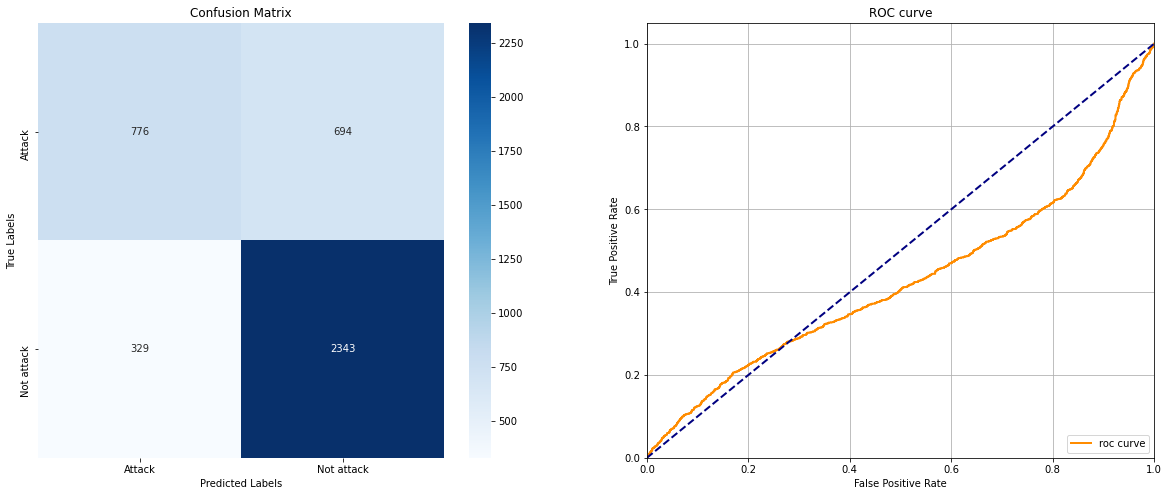

Accuracy is: 0.7530178657653308
Precision is: 0.702262443438914
Recall is: 0.527891156462585
F1 score is: 0.6027184466019417


In [14]:
pred = evaluate(model,dev_iter)

Classification Report:
              precision    recall  f1-score   support

           1     0.6471    0.6914    0.6685       175
           0     0.9171    0.9005    0.9087       663

    accuracy                         0.8568       838
   macro avg     0.7821    0.7959    0.7886       838
weighted avg     0.8607    0.8568    0.8585       838



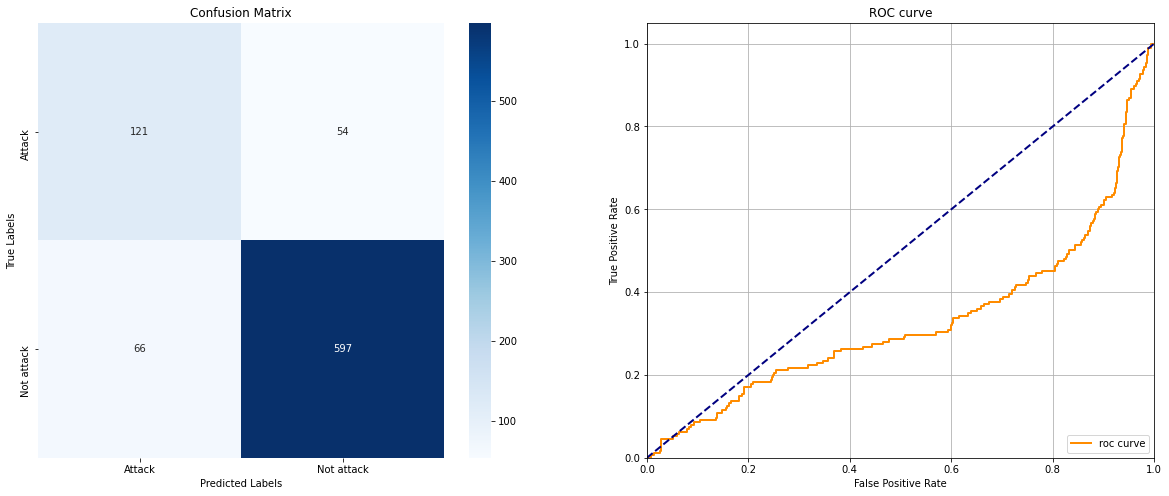

Accuracy is: 0.8568019093078759
Precision is: 0.6470588235294118
Recall is: 0.6914285714285714
F1 score is: 0.6685082872928177


In [15]:
pred = evaluate(model,test_iter)

In [13]:
# model structure for roberta
model

ROBERTAClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
import pandas as pd
Test_cleaned = pd.read_csv('source_folder/test_df.csv')

In [18]:
print("The sample data set are:")
print("bert model 2:", (Test_cleaned['sentences'][0]), 'Lable is:',Test_cleaned['label'][0], "Prediction:", pred[0])
print("bert model 2:", (Test_cleaned['sentences'][20]), 'Lable is:',Test_cleaned['label'][20], "Prediction:", pred[20])

The sample data set are:
bert model 2: [CLS] all the home alones watching 8 mile [SEP] the last rap battle in 8 mile nevr gets old ahah Lable is: 0 Prediction: 0
bert model 2: [CLS] ok good the end of 8 mile is on [SEP] the end of 8 mile makes me so happy Lable is: 1 Prediction: 0
